In [1]:
import pandas as pd
pd.options.io.excel.xlsx.writer = 'xlsxwriter'

dataset = pd.read_csv(r'./datas/数字化差异性分析数据.csv', index_col=None, header=0, dtype={'股票代码':'object'})
js_dataset = dataset[dataset['上市省份']=='江苏']
print(js_dataset[js_dataset['digital']==1].shape[0])  # 只有236个数据是1，但是我们不提的话或许可以提高准确率。
# js_dataset.reset_index(inplace=True, drop=True)
# 删除不需要的数据
js_dataset = js_dataset.drop(['上市省份'], axis=1)
js_dataset

650


,股票代码,截止日期,企业年限,行业类别,权益乘数,速动比率,资本积累率B,固定资产增长率B,营业总收入增长率,销售费用增长率,...,股权性质,两权分离度(%),股权集中度4(%),独董比例,提供岗位增长率,员工收入增长率,研发强度,创新产出,董事会规模,digital
314,000301,2007,7.0,13.0,1.380405,0.668586,-0.006589,-0.273977,0.006221,0.041691,...,1,0.000000,40.2903,0.333333,0.263699,0.166207,2.003051,0.000000,2.302585,0
315,000301,2008,8.0,13.0,1.546510,0.492229,0.082254,-0.350255,-0.463183,-0.710069,...,1,0.000000,41.2454,0.333333,-0.394657,0.166207,2.003051,0.000000,2.302585,0
316,000301,2009,9.0,13.0,1.561810,0.724658,0.006033,-0.143850,-0.085466,0.813145,...,1,0.000000,43.7998,0.400000,0.069272,0.166207,2.003051,0.000000,2.397895,0
317,000301,2010,10.0,60.0,1.470518,1.270975,0.025920,-0.096754,0.233287,-0.668786,...,1,0.000000,41.7098,0.571429,0.028239,0.166207,2.003051,0.000000,2.079442,0
318,000301,2011,11.0,60.0,1.360832,1.019489,0.005543,-0.170452,0.170210,2.126254,...,1,0.000000,39.9150,0.384615,0.009693,0.166207,2.003051,0.000000,2.639057,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26718,870436,2022,1.0,32.0,1.778334,1.436806,-0.097942,-0.056501,-0.382923,-0.163350,...,0,16.988600,76.5233,0.333333,-0.030721,-0.114466,2.284421,4.234107,2.302585,0
26719,871396,2021,1.0,36.0,1.485790,2.525995,0.087010,-0.105547,-0.020185,-0.168257,...,0,5.108174,63.0868,0.250000,0.263699,0.166207,1.619388,2.708050,2.302585,1
26720,871396,2022,2.0,36.0,1.476032,2.110647,0.056330,0.182788,-0.087836,-0.070228,...,0,5.108174,63.0972,0.250000,0.010714,-0.048795,1.733424,3.496508,2.302585,1
26723,871642,2021,0.0,25.0,1.362160,1.854867,0.512965,0.379445,0.104335,0.105209,...,0,0.440000,71.3047,0.428571,0.263699,0.166207,2.512846,2.397895,2.079442,0


In [2]:
from sklearn.model_selection import train_test_split

head = ['股票代码','截止日期']
Xnames=['企业年限', '行业类别', '权益乘数', '速动比率', '资本积累率B', '固定资产增长率B', '营业总收入增长率', '销售费用增长率', '管理费用增长率', '现金资产比率', '全部现金回收率', '净利润现金净含量', '营运指数', '资本支出与折旧摊销比', '营业净利率', '销售期间费用率', '投入资本回报率（ROIC）', '成本费用利润率', '应付账款周转率B', '存货周转率B', '应收账款周转率B', '经营杠杆', '财务杠杆', '两职合一', '本期销售额占年度销售总额比例(%)', '本期采购额占年度采购总额比例(%)', '股权性质', '两权分离度(%)', '股权集中度4(%)', '独董比例', '提供岗位增长率', '员工收入增长率', '研发强度', '创新产出', '董事会规模']
Ynames=['digital']
headset = js_dataset[head]
# 对数据进行标准化，数据量有点大，可以尝试单纯拿出江苏省数据先进行分析
# 思路A:是不是可以进一步对全国数据通过行业筛选研究？
def normalize(matrix:pd.DataFrame, method='z'):
    """
    :param matrix: 
    :param method: z/m/other
    :return: 
    """
    directions=[
        ['销售期间费用率','总营业成本率','应付账款周转率B','存货周转率B','资产负债率','负债与权益市价比率',
         '销售费用增长率','管理费用增长率','营业总成本增长率'],
        ['企业年限', '现金比率', '速动比率','产权比率', '权益乘数', '经营活动产生的现金流量净额／负债合计', '流动比率', '总资产增长率B', '资本保值增值率B', '营业总收入增长率', '固定资产增长率B', '资本积累率B',
         '现金资产比率', '营业收入现金净含量', '资本支出与折旧摊销比', '营运指数', '全部现金回收率', '净利润现金净含量', '投入资本回报率（ROIC）', '成本费用利润率', '营业利润率', '总资产净利润率(ROA)C',
         '营业净利率', '应收账款周转率B', '财务杠杆', '经营杠杆', '董事会规模', '两职合一', '股权性质', '两权分离度(%)', '股权集中度4(%)', '创新投入', '内部控制指数', '财务波动', '长期绩效增长',
         '组织韧性', '独董比例', '供应链集中能力', '提供岗位增长率', '员工收入增长率', '研发强度', '创新产出', '行业类别'],
        ['股票代码', '截止日期', '股票简称', '上市省份', 'digital']
    ]
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    if method=='z':
        # z_score标准化
        zscore = StandardScaler()
        return zscore.fit_transform(matrix)
    elif method=='m':
        # 不考虑指标方向的极差标准化
        minmax = MinMaxScaler()
        return minmax.fit_transform(matrix)
    else:
        metrix = matrix.copy()
        for name, item in metrix.items():
            max_ = item.max()
            min_ = item.min()
            if name in directions[0]:
                for index, row in item.items():
                    metrix.loc[index, name] = (max_ - metrix.loc[index, name]) / (max_ - min_)
            elif name in directions[1]:
                for index, row in item.items():
                    metrix.loc[index, name] = (metrix.loc[index, name] - min_) / (max_ - min_)
        return metrix

X = normalize(js_dataset[Xnames], method='m')
X = pd.DataFrame(X,columns=Xnames)
y = js_dataset[Ynames].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error # 均方误差
# https://www.python100.com/html/105762.html
# adam;lbfgs
layris=101
start = 1
best_score = 0
scores=[]
val_mses=[]
mses=[]


# 大约需要12h
best_sizes = (start, start)
for i in range(start, layris):
    for j in range(start, layris):
        # lbfgs:适合小数据集合; activation='tanh'
        new_model = MLPClassifier(solver='adam',batch_size=516, hidden_layer_sizes=(i, j), random_state=123, max_iter=10000)
        new_model.fit(X_train, y_train)
        score = new_model.score(X_test, y_test)
        val_mse = mean_squared_error(y_test, new_model.predict(X_test))
        mse = mean_squared_error(y_train, new_model.predict(X_train))
        scores.append(score)
        mses.append(mse)
        val_mses.append(val_mse)
        if best_score < score:
            best_score = score
            best_sizes = (i, j)  

In [4]:
best_sizes

(45, 91)

In [13]:
import numpy as np
from sklearn.neural_network import MLPClassifier

best_sizes = (45,91)
model = MLPClassifier(solver='adam', hidden_layer_sizes=best_sizes, random_state=123, max_iter=100000)
print(best_sizes)
model.fit(X_train, y_train)
print(f"R方:{model.score(X_test, y_test):.4f}; 迭代次数{model.n_iter_}")

(45, 91)
R方:0.8283; 迭代次数591


ValueError: x and y must have same first dimension, but have shapes (10200,) and (10000,)

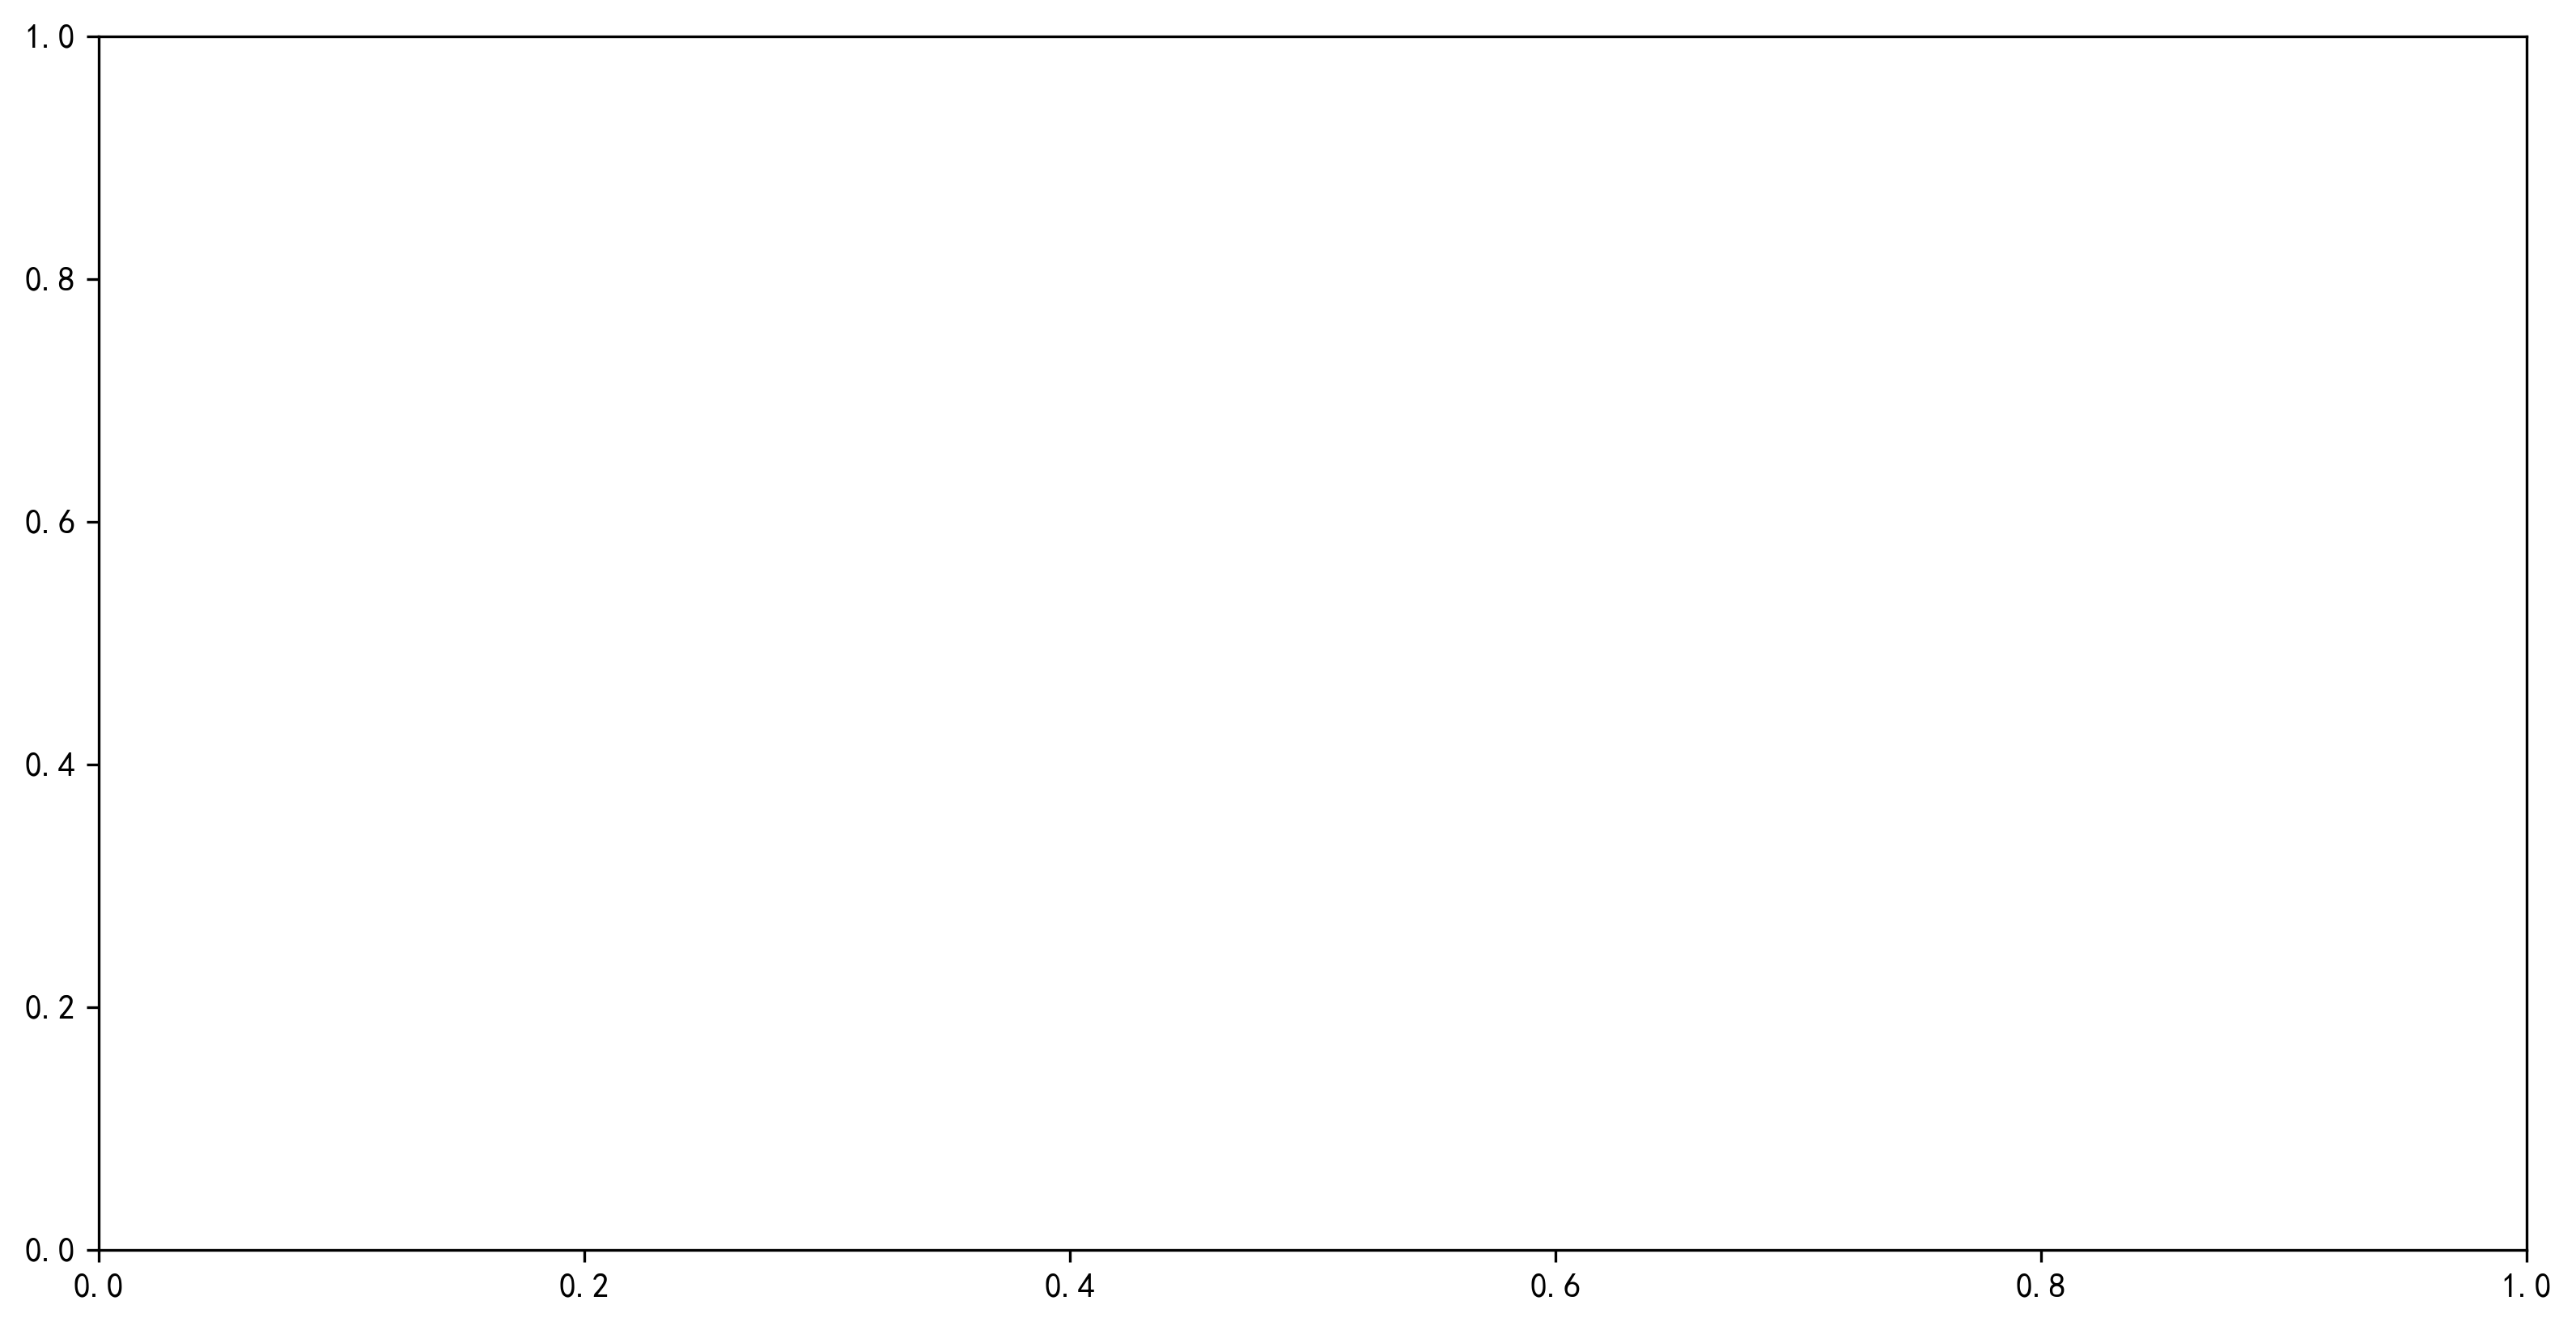

In [9]:
import matplotlib.pylab as plt
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False    # 用来正常显示负号

fig = plt.figure(figsize=(10, 5),dpi=300)
ax = fig.add_axes([0,0,1,1])
start = 1

index = np.argmax(scores)
ax.plot(range(start, layris**2), scores, 'o-')
ax.axvline(range(start, layris**2)[index], linestyle='--', color='k', linewidth=1)
ax.set_xlabel('Number of Nodes')
ax.set_ylabel('R2')
plt.title('Test Set R2 vs Number of Nodes')
plt.show()

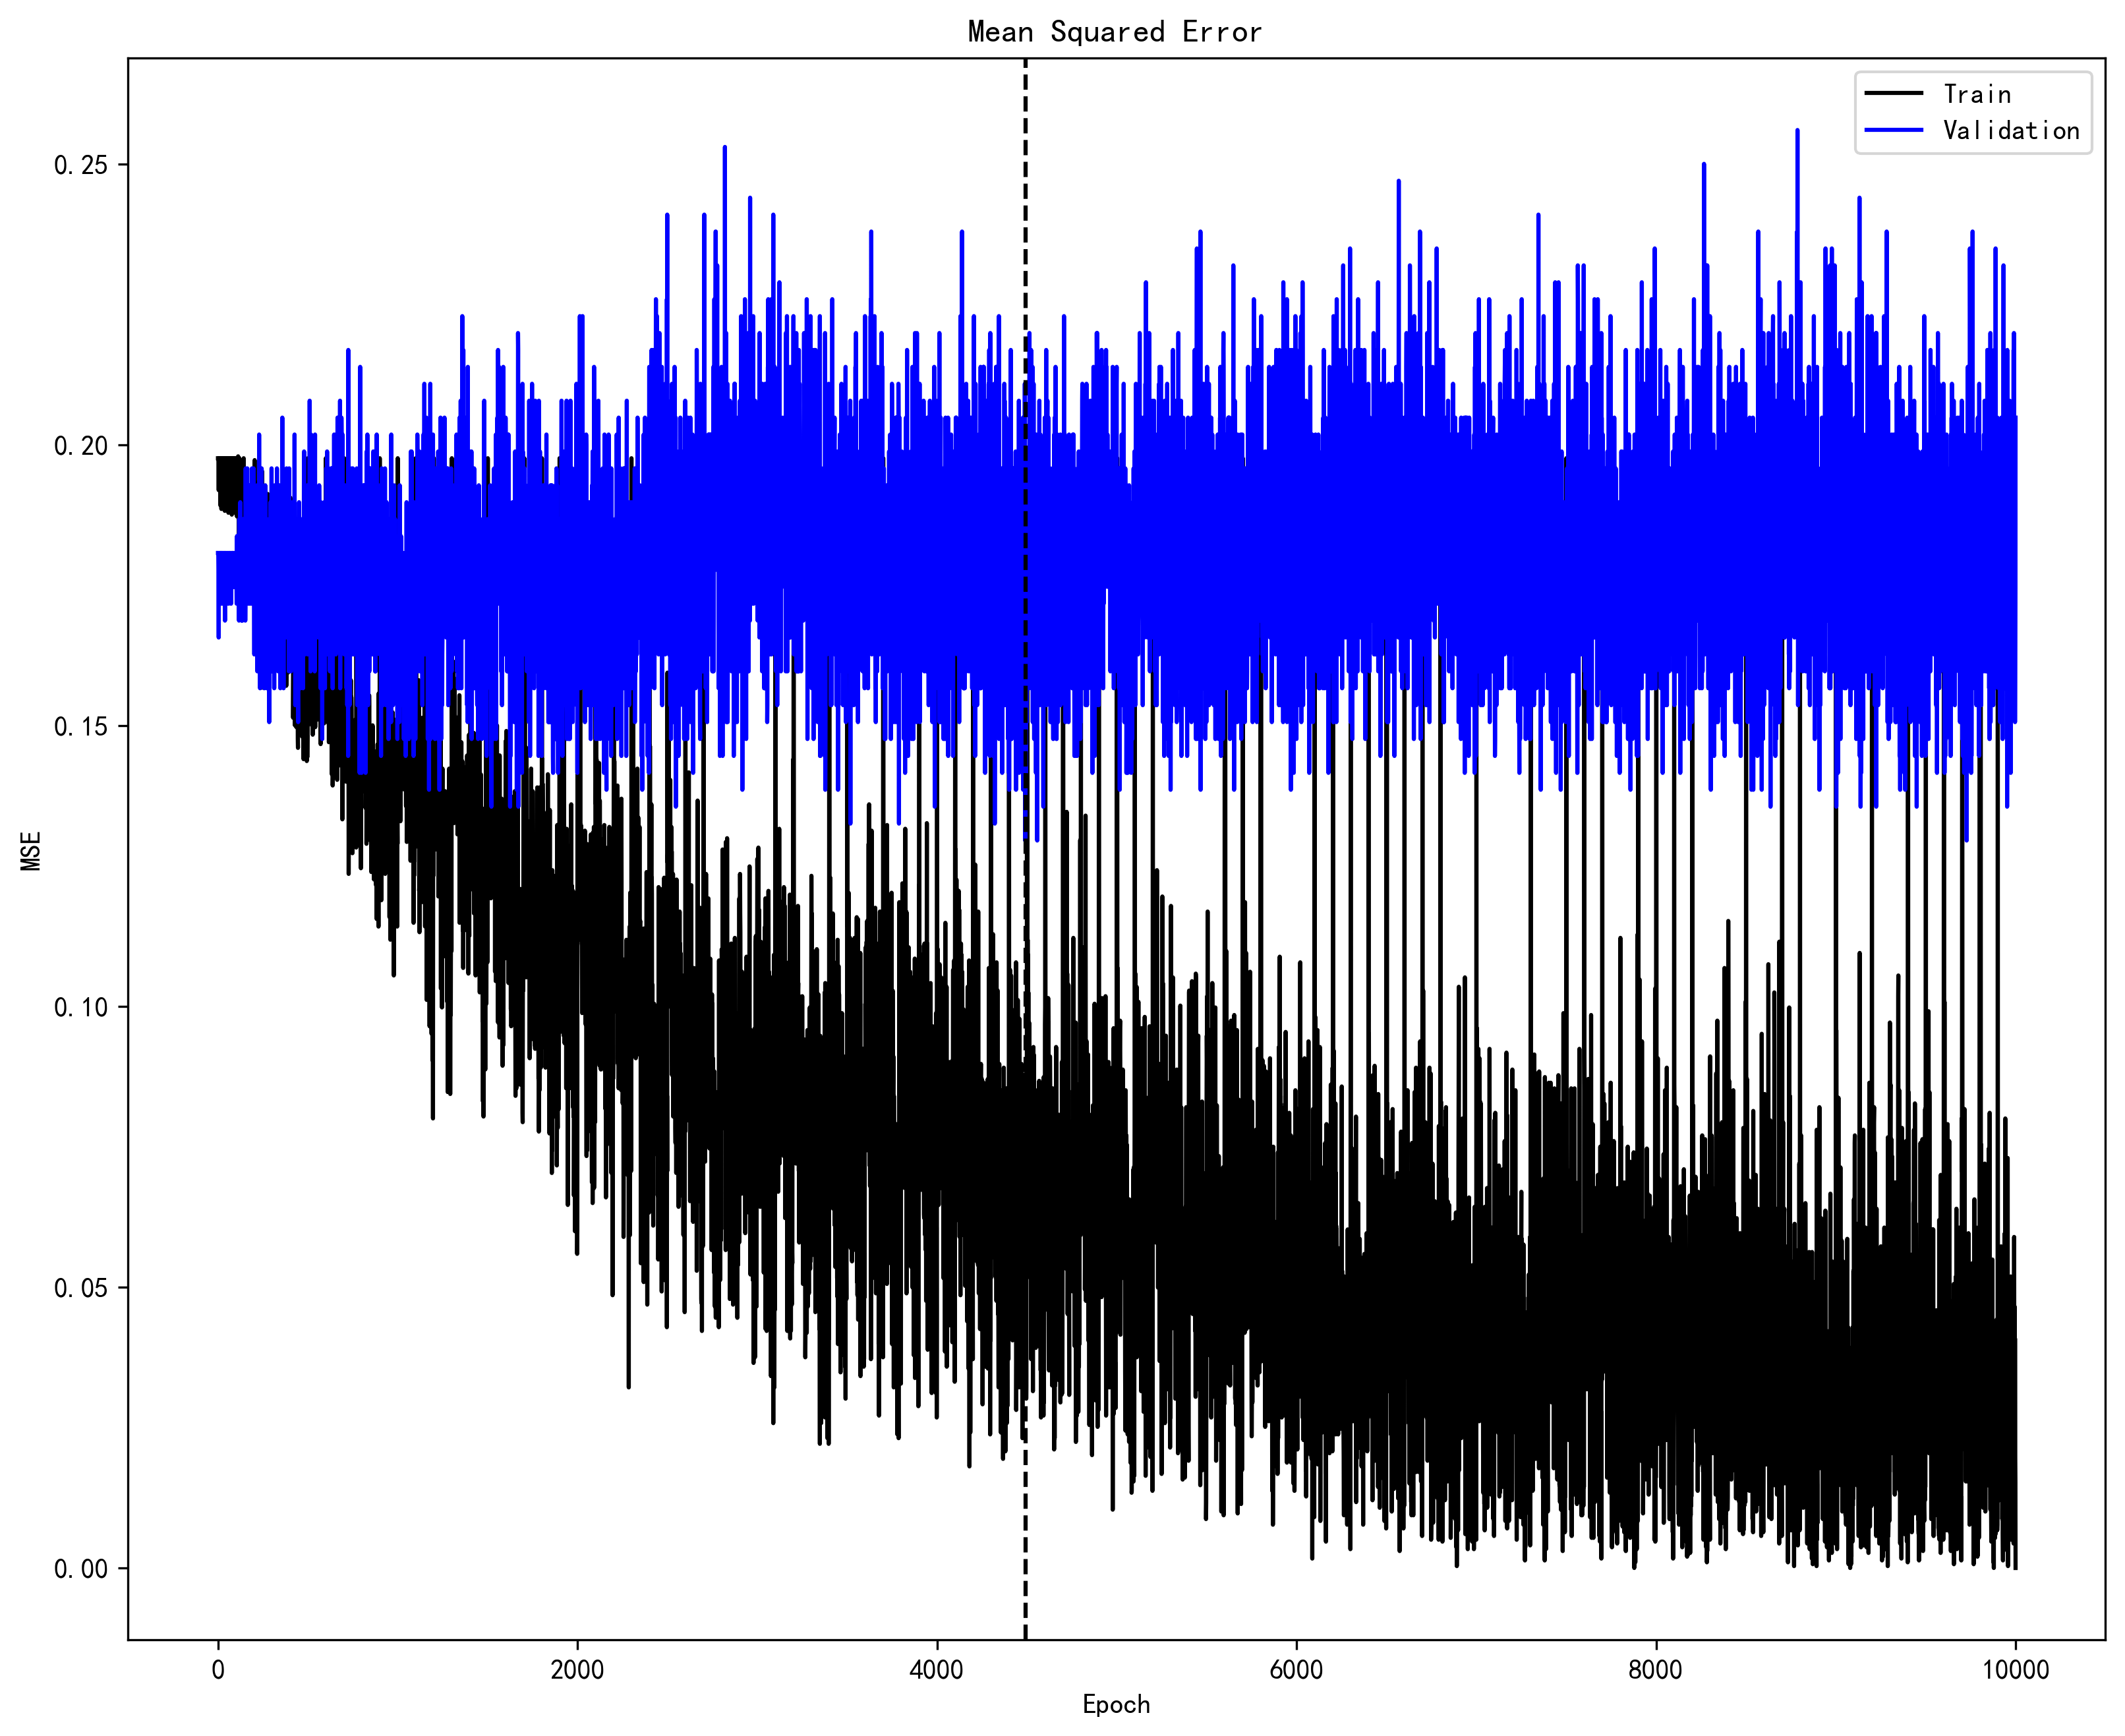

In [10]:
fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_axes([0,0,1,1])
index = np.argmin(val_mses)
ax.plot(mses,'k', label='Train')
ax.plot(val_mses,'b', label='Validation')
ax.axvline(index+1, linestyle='--', color='k')

ax.set_ylabel('MSE')
ax.set_xlabel('Epoch')
plt.title('Mean Squared Error')
plt.legend()
plt.show()

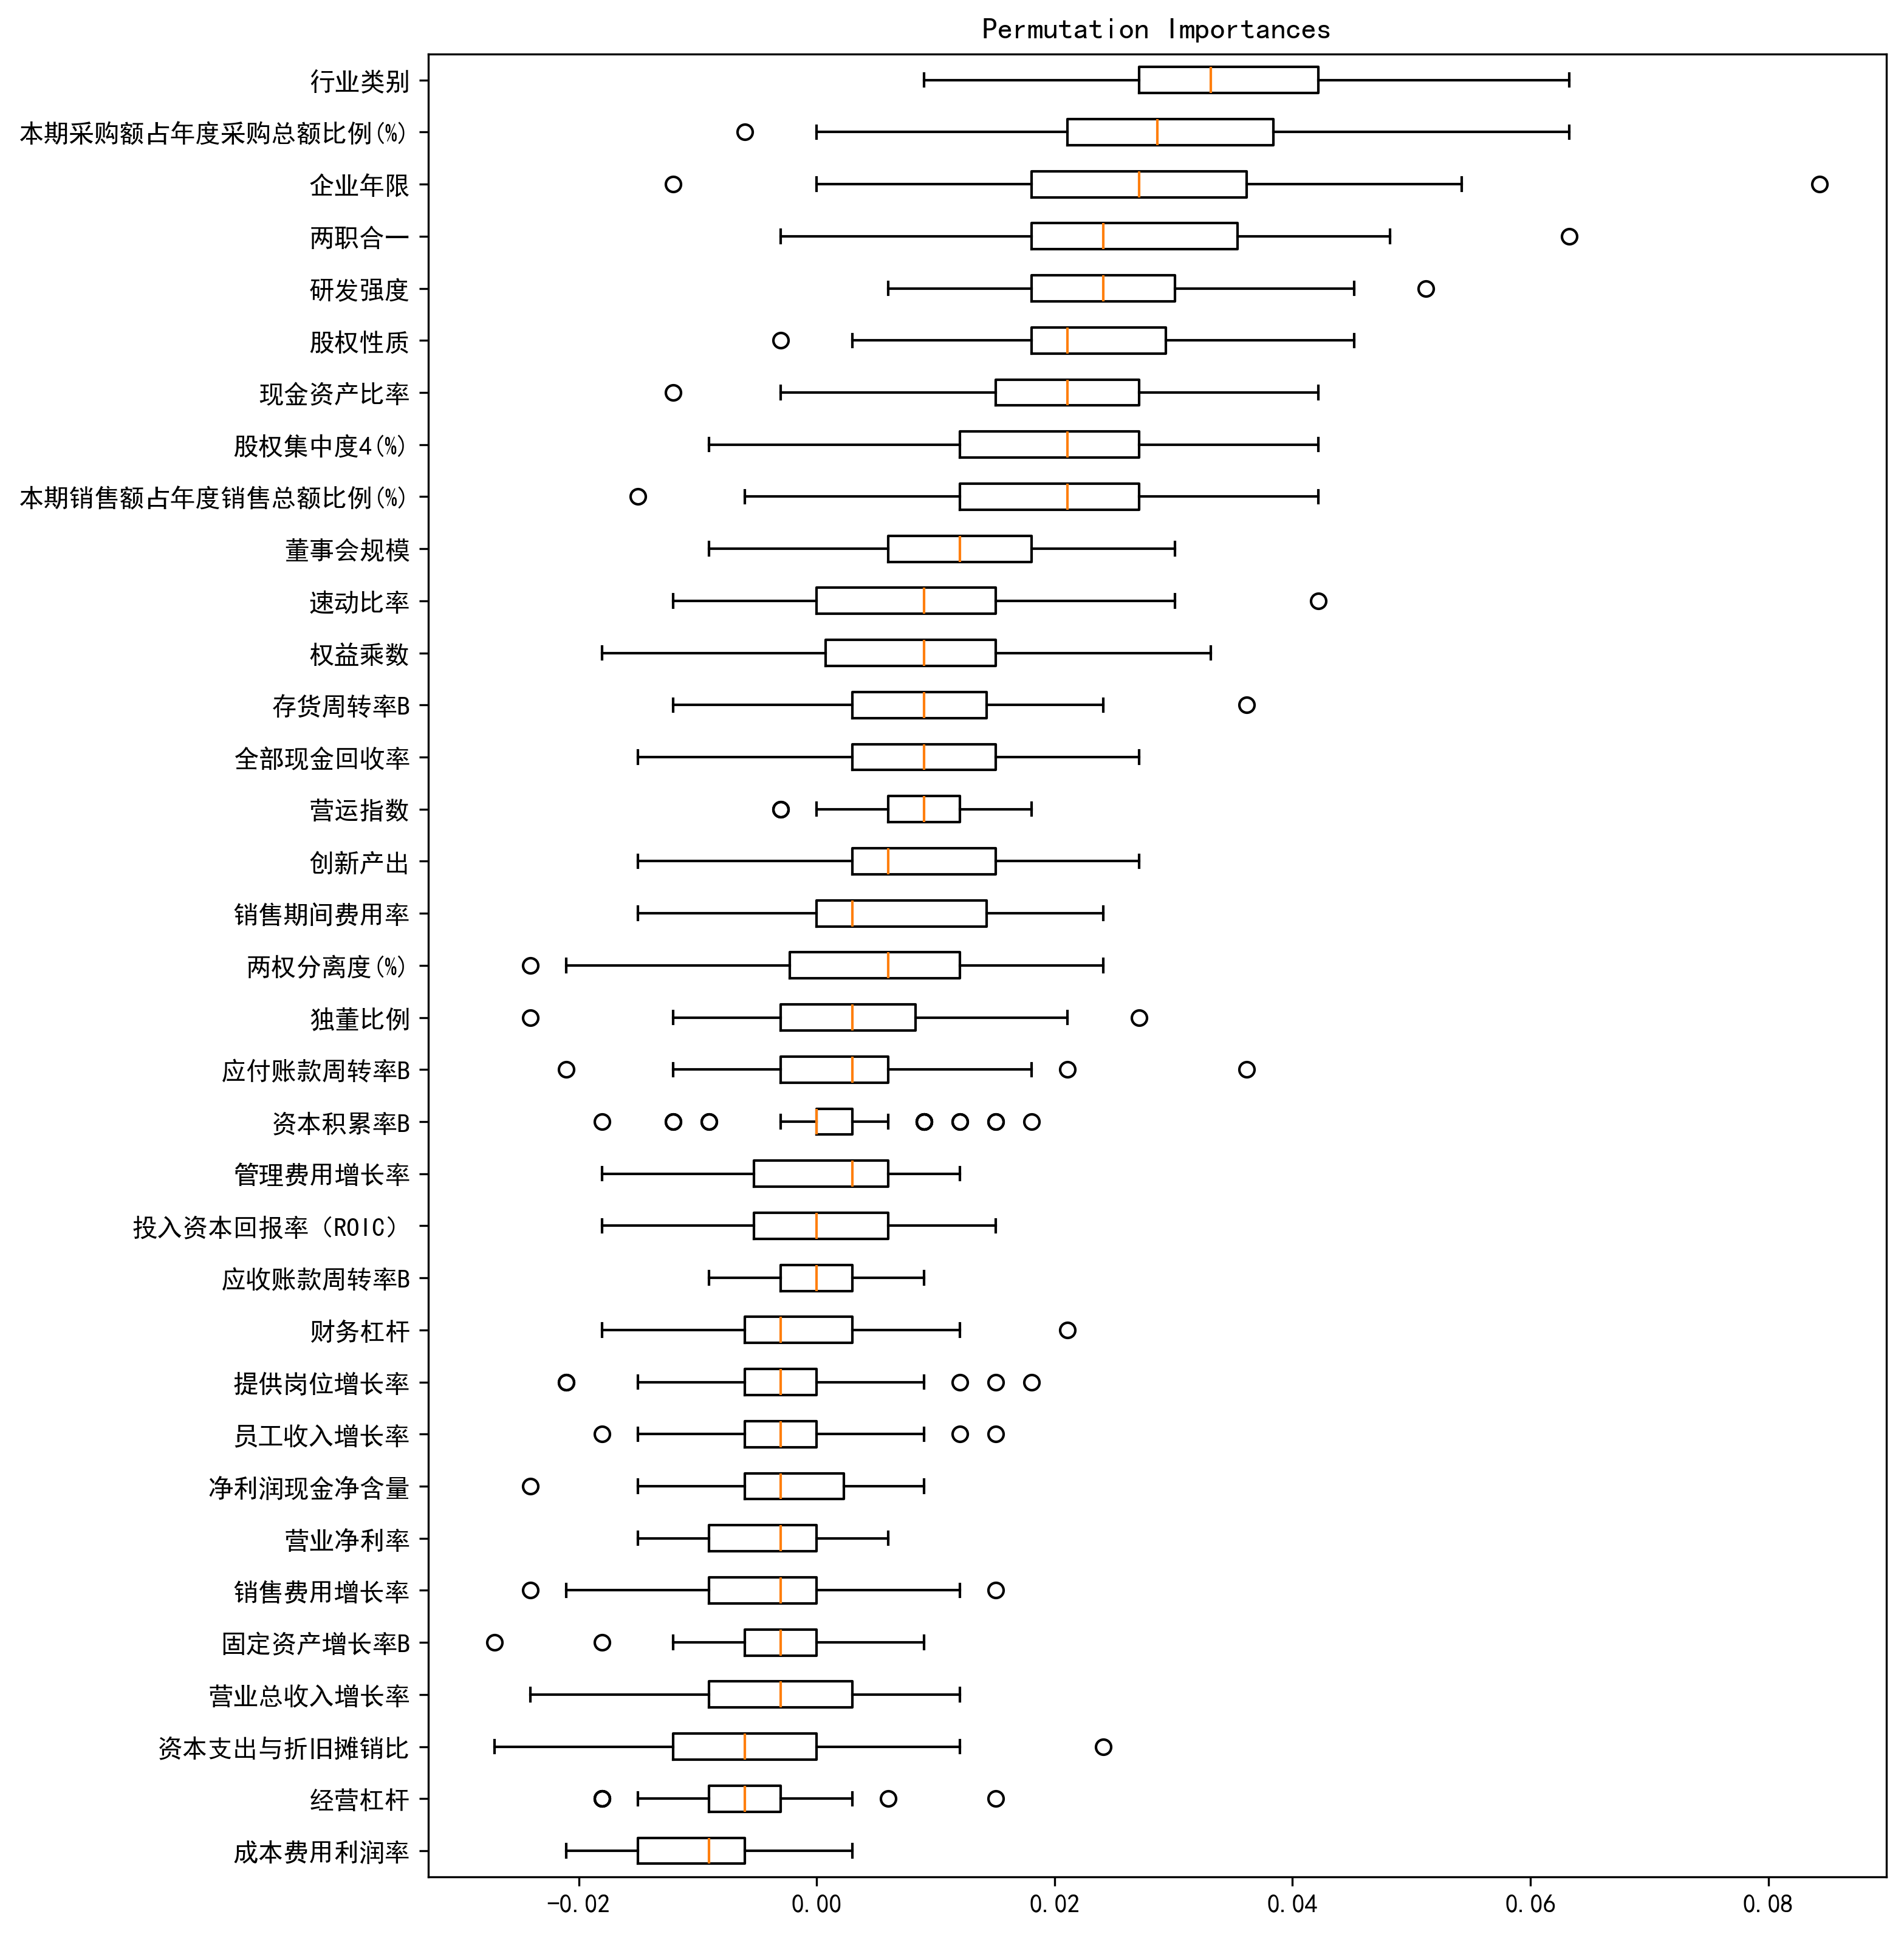

In [11]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

Bunch_result = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42)
# n_repeats=20：进行50次随机替换
# Bunch_result:[importance(置换重要度),importance_mean（置换重要度均值）,importance_std（置换重要度标准差）]

Bunch_index = Bunch_result.importances_mean.argsort()
nlabels = [Xnames[i] for i in Bunch_index]

fig = plt.figure(figsize=(8, 10),dpi=300)
ax = fig.add_axes([0,0,1,1])

# Bunch_index = Bunch_result.importances_mean.argsort()
ax.boxplot(Bunch_result.importances[Bunch_index].T, vert=False,labels=nlabels)  #  labels=Xnames

plt.title('Permutation Importances')
plt.show()